# DDPG for Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Train the agent with the DDPG algorithm

The task is episodic, and in order to solve the environment, the agent must get an average score of +30 over 100 consecutive episodes.

We start by importing hte necessary packages for DDPG.

In [5]:
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent import Agent
import torch
import time

%matplotlib inline
%config InlineBackend.figure_format='retina'

Next we define the way the DDPG is run:

In [6]:
def ddpg(n_episodes=1000, max_steps=2000, learn_interval = 20, 
         learn_repeats = 20, target_score = 30.0):
    scores_deque = deque(maxlen=100)
    running_scores = []
    average_score = []
    
    # instantiates agent from environment data
    agent = Agent(state_size=state_size, action_size=action_size, random_seed=7)

    for i_episode in range(1, n_episodes+1):
        # log the start time to calculate the episode period
        start_time = time.time()
        
        # reset the environment between episodes
        env_info = env.reset(train_mode=True)[brain_name]
        
        # get the first state
        states = env_info.vector_observations

        # reset the agent noise
        agent.reset()
        
        # reset scores
        scores = np.zeros(num_agents)
        
        for t in range(max_steps):
            # Gets agents net array of actions
            actions = agent.act(states)

            # send the actions to environment
            env_info = env.step(actions)[brain_name]
            
            # reads the next state
            next_states = env_info.vector_observations
            
            # readrs the reward
            rewards = env_info.rewards
            
            # reads if the episode is finished
            dones = env_info.local_done
            
            # sends information from the 20 simulations to agent
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            
            
            #agent.step(state, actions, reward, next_state, done)
            
            # update the state
            states = next_states
            
            # update the score
            scores += rewards
            
            # start a learning phase every learn_interval steps
            if t % learn_interval == 0:
                # train for learn_repeats cycles
                for i in range(learn_repeats):
                    agent.start_learn()
                
            
            # if the episode is done, the break
            if np.any(dones):
                break
 
        scores_deque.append(np.mean(scores))
        running_scores.append(np.mean(scores))
        average_score.append(np.mean(scores_deque))
        # display the current result
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tPeriod: {:.2f}s'.format(i_episode, np.mean(scores_deque), np.mean(scores), time.time() - start_time))
        
        # save the model every 10 steps
        if i_episode % 10 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        # quit if we have reached the target
        if np.mean(scores_deque) >= target_score:
            print('Solved after {} epsisodes. Total Average score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    
    return running_scores, average_score

Finally, we run and display the results:

In [7]:
running_scores, average_score = ddpg()

C:\Users\Home\Anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1	Average Score: 0.87	Score: 0.87	Period: 50.92s
Episode 2	Average Score: 0.87	Score: 0.87	Period: 52.68s
Episode 3	Average Score: 0.95	Score: 1.10	Period: 54.14s
Episode 4	Average Score: 1.07	Score: 1.45	Period: 54.05s
Episode 5	Average Score: 1.16	Score: 1.51	Period: 55.55s
Episode 6	Average Score: 1.23	Score: 1.59	Period: 58.01s
Episode 7	Average Score: 1.55	Score: 3.45	Period: 57.25s
Episode 8	Average Score: 2.16	Score: 6.46	Period: 57.06s
Episode 9	Average Score: 2.69	Score: 6.90	Period: 57.48s
Episode 10	Average Score: 3.52	Score: 11.02	Period: 58.39s
Episode 11	Average Score: 4.54	Score: 14.72	Period: 58.18s
Episode 12	Average Score: 5.90	Score: 20.80	Period: 59.97s
Episode 13	Average Score: 7.41	Score: 25.58	Period: 60.97s
Episode 14	Average Score: 9.15	Score: 31.83	Period: 62.69s
Episode 15	Average Score: 10.95	Score: 36.16	Period: 62.48s
Episode 16	Average Score: 12.60	Score: 37.34	Period: 65.75s
Episode 17	Average Score: 14.05	Score: 37.24	Period: 61.94s
Episode 18	A

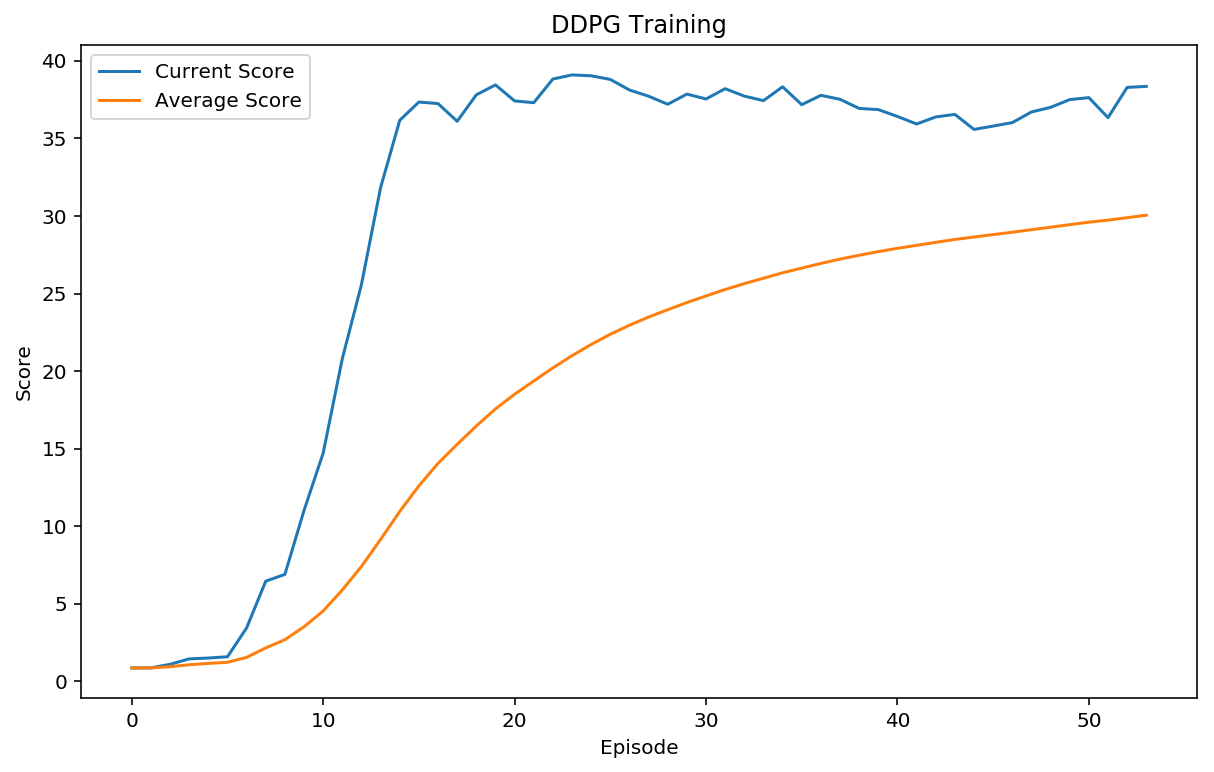

In [20]:
fig = plt.figure(figsize=(10,6))

plt.plot(running_scores, label='Current Score')
plt.plot(average_score, label='Average Score')
plt.title('DDPG Training')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend()
plt.show()

This was too fast, so we'll force the program to run the full 100 episodes

In [31]:
def ddpg2(n_episodes=100, max_steps=2000, learn_interval = 20, 
         learn_repeats = 20, target_score = 30.0):
    scores_deque = deque(maxlen=100)
    running_scores = []
    average_score = []
    
    # instantiates agent from environment data
    agent = Agent(state_size=state_size, action_size=action_size, random_seed=7)

    for i_episode in range(1, n_episodes+1):
        # log the start time to calculate the episode period
        start_time = time.time()
        
        # reset the environment between episodes
        env_info = env.reset(train_mode=True)[brain_name]
        
        # get the first state
        states = env_info.vector_observations

        # reset the agent noise
        agent.reset()
        
        # reset scores
        scores = np.zeros(num_agents)
        
        for t in range(max_steps):
            # Gets agents net array of actions
            actions = agent.act(states)

            # send the actions to environment
            env_info = env.step(actions)[brain_name]
            
            # reads the next state
            next_states = env_info.vector_observations
            
            # readrs the reward
            rewards = env_info.rewards
            
            # reads if the episode is finished
            dones = env_info.local_done
            
            # sends information from the 20 simulations to agent
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            
            
            #agent.step(state, actions, reward, next_state, done)
            
            # update the state
            states = next_states
            
            # update the score
            scores += rewards
            
            # start a learning phase every learn_interval steps
            if t % learn_interval == 0:
                # train for learn_repeats cycles
                for i in range(learn_repeats):
                    agent.start_learn()
                
            
            # if the episode is done, the break
            if np.any(dones):
                break
 
        scores_deque.append(np.mean(scores))
        running_scores.append(np.mean(scores))
        average_score.append(np.mean(scores_deque))
        
        # display the current result
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tPeriod: {:.2f}s'.format(i_episode, np.mean(scores_deque), np.mean(scores), time.time() - start_time))
        
    # save the model
    print("Finished")
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor2.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic2.pth')

    
    return running_scores, average_score

In [32]:
running_scores2, average_score2 = ddpg2()

C:\Users\Home\Anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1	Average Score: 0.78	Score: 0.78	Period: 51.11s
Episode 2	Average Score: 0.89	Score: 0.99	Period: 54.09s
Episode 3	Average Score: 0.94	Score: 1.05	Period: 55.13s
Episode 4	Average Score: 1.10	Score: 1.56	Period: 55.39s
Episode 5	Average Score: 1.24	Score: 1.83	Period: 55.54s
Episode 6	Average Score: 1.34	Score: 1.80	Period: 58.41s
Episode 7	Average Score: 1.50	Score: 2.46	Period: 57.78s
Episode 8	Average Score: 1.68	Score: 2.97	Period: 57.35s
Episode 9	Average Score: 1.88	Score: 3.50	Period: 57.94s
Episode 10	Average Score: 2.20	Score: 5.09	Period: 58.24s
Episode 11	Average Score: 2.56	Score: 6.12	Period: 58.72s
Episode 12	Average Score: 3.05	Score: 8.42	Period: 60.23s
Episode 13	Average Score: 3.69	Score: 11.44	Period: 59.78s
Episode 14	Average Score: 4.48	Score: 14.65	Period: 62.89s
Episode 15	Average Score: 5.41	Score: 18.53	Period: 62.05s
Episode 16	Average Score: 6.57	Score: 23.95	Period: 62.72s
Episode 17	Average Score: 7.71	Score: 25.83	Period: 63.45s
Episode 18	Average

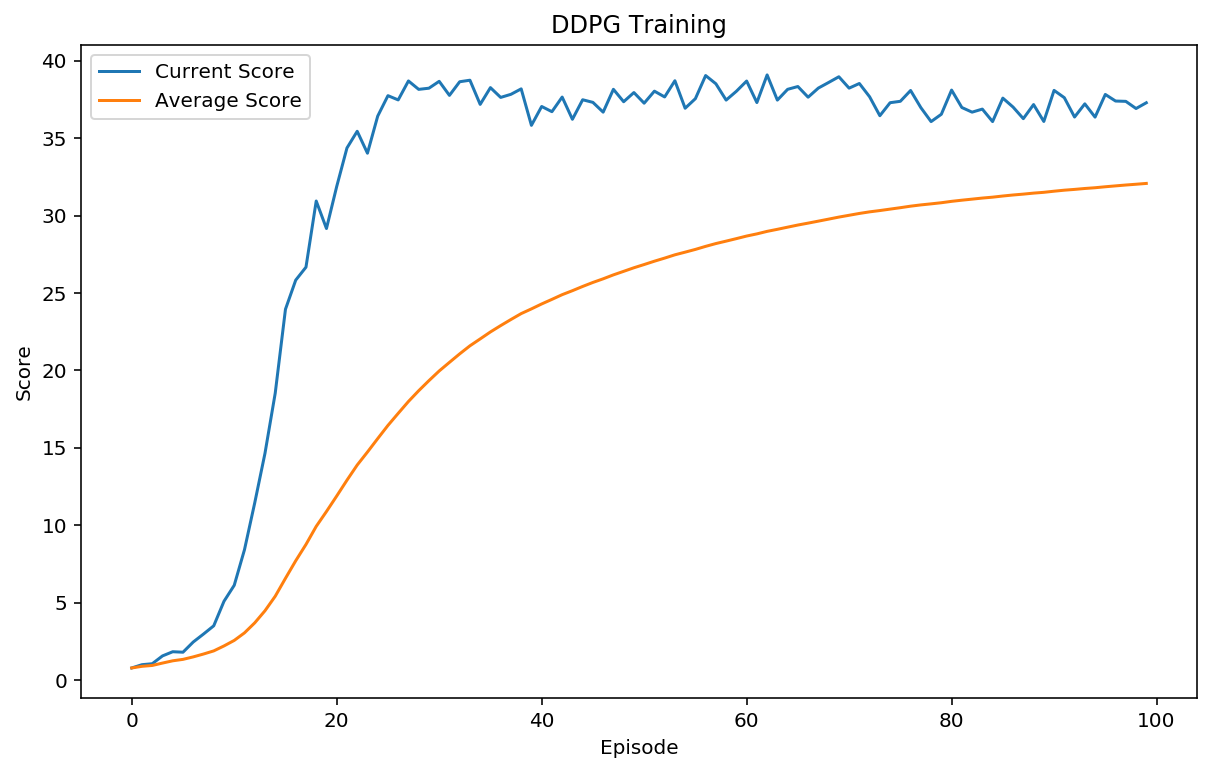

In [33]:
fig = plt.figure(figsize=(10,6))

plt.plot(running_scores2, label='Current Score')
plt.plot(average_score2, label='Average Score')
plt.title('DDPG Training')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend()
plt.show()

### 3. Use the trained DDPG to demo the robots

In the next code cell, we load the 'memories' of the training into the model, and then run the network.
This way we can generate a movie of the actions of the trained system.

In [29]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment 

# set up agent and load memories
agent = Agent(state_size=state_size, action_size=action_size, random_seed=7)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))


states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
for i_ticks in range(100):
    # Gets agents net array of actions
    actions = agent.act(states)

    # send the actions to environment
    env_info = env.step(actions)[brain_name]

    next_states = env_info.vector_observations         # get next state (for each agent)
    states = next_states                               # roll over states to next time step



C:\Users\Home\Anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


When finished, you can close the environment.

In [ ]:
env.close()